In [25]:
from googleapiclient.discovery import build
import pandas as pd
from IPython.display import JSON
from dateutil import parser
import isodate
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# # NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
# from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to /home/nhat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nhat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
from dotenv import load_dotenv
import os
load_dotenv()

api_key = os.getenv("api_key")

In [36]:
channel_ids = ['UCIUt1auGAZGqo3jmeP-LB1g','UCQxFc2GZvTAfwgikTwPJSkA',]

In [37]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)


In [38]:
def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

In [39]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [40]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Vê Tê Lờ,47,17347,66,UUIUt1auGAZGqo3jmeP-LB1g
1,Toàn Nguyễn,256000,56851349,1823,UUQxFc2GZvTAfwgikTwPJSkA


In [15]:
playlist_id = "UUQxFc2GZvTAfwgikTwPJSkA"

def get_video_ids(youtube, playlist_id):

    video_ids = []

    request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId=playlist_id,
            maxResults=50
        )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part='contentDetails',
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token
        )

        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        
        next_page_token = response.get('nextPageToken')

    return video_ids

In [16]:
video_ids = get_video_ids(youtube, playlist_id)

In [17]:
len(video_ids)

1824

In [40]:
def get_video_details(youtube, video_ids):
    
    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet, contentDetails, statistics",
            id=','.join(video_ids[i:i+50])
        )

        response = request.execute()
        
        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None
            
            all_video_info.append(video_info)
        
    return pd.DataFrame(all_video_info)

In [41]:
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,WfyaSfkA96g,Toàn Nguyễn,5 Điều đàn bà thông minh nhất định phải làm tr...,5 Điều đàn bà thông minh nhất định phải làm tr...,"[Toàn Nguyễn, toan nguyen, tình yêu bí quyết, ...",2023-03-03T13:00:21Z,291,21,None,0,PT10M17S,hd,false
1,xDoIL9Bqfi0,Toàn Nguyễn,Kiểu người ko nên yêu #shorts,,None,2023-03-02T13:29:15Z,2319,69,None,0,PT55S,hd,false
2,uIqdIQR9bIY,Toàn Nguyễn,thích quà nào hơn #shorts,,None,2023-03-02T13:11:52Z,859,51,None,0,PT26S,hd,false
3,zpm1mZgLQ4Q,Toàn Nguyễn,5 Nguyên tắc ứng xử tiền bạc với đàn ông của p...,5 Nguyên tắc ứng xử tiền bạc với đàn ông của p...,"[Toàn Nguyễn, toan nguyen, tình yêu bí quyết, ...",2023-03-02T13:00:42Z,2540,112,None,0,PT14M46S,hd,false
4,t9ZOmUzBNhk,Toàn Nguyễn,Người ấy muốn dừng lại? Hãy nói câu này #short,,None,2023-03-01T14:21:08Z,6537,147,None,0,PT58S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,9f6BxN2boCY,Toàn Nguyễn,Top 5 điều đàn ông thấy hấp dẫn ở phụ nữ - Bí ...,Bạn chưa hạnh phúc trong tình yêu? bạn tự hỏi ...,"[Top 5 điều đàn ông thấy hấp dẫn ở phụ nữ, Bí ...",2019-05-05T10:58:45Z,42867,729,None,27,PT12M26S,hd,false
1795,d5VcLUAjntA,Toàn Nguyễn,Tại sao con gái hay giận dỗi và tầm quan trọng...,Nếu đã hơn một lần đặt câu hỏi tại sao con gái...,[Tại sao con gái hay giận dỗi và tầm quan trọn...,2019-05-03T13:43:58Z,29449,527,None,41,PT10M40S,hd,false
1796,8-3_1AviAIk,Toàn Nguyễn,Tổng hợp các cách kết hợp quần ống rộng đầy đủ...,Bạn yêu thích quần ống rộng nhưng không biết m...,"[tổng hợp cách kết hợp quần ống rộng, tong hop...",2018-06-09T01:09:03Z,77078,254,None,5,PT21M25S,hd,false
1797,XVOmSkIaQro,Toàn Nguyễn,8 Bí Quyết Thời Trang Giúp Bạn Luôn Sang Trọng...,Làm sao để bạn luôn sang trọng mỗi ngày? Những...,[8 bí quyết thời trang giúp bạn luôn sang trọn...,2018-04-16T15:37:53Z,143431,738,None,24,PT10M13S,hd,false


In [16]:
def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)     


In [17]:
comments_df = get_comments_in_videos(youtube, video_ids)

Could not get comments for video wCMJ0uMAAeo
Could not get comments for video _5p0_R5osR8
Could not get comments for video VBS-VG264gU


In [61]:
comments_df

,video_id,comments
0,1XADpb94foI,[]
1,GriL5mOucOI,[]
2,a7eNWhEp0-4,"[đầm ấm quá ạ, happy new year]"
3,xyDoFxlYXl4,[]
4,cJ7XUMFVarc,[kết vội thế anh zai]
...,...,...
58,8uEFzXc5p5g,[]
59,WcsU3UfFXAg,[]
60,lDAKtJvvVOc,[]
61,ORWg20EIWvc,[]


In [60]:
len(comments_df)

63

Data preprocessing

In [64]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [65]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [66]:
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [70]:
#Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x :x.strftime("%A"))

In [71]:
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]') 

In [72]:
video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,318.0,PT5M18S
1,113.0,PT1M53S
2,21.0,PT21S
3,138.0,PT2M18S
4,235.0,PT3M55S
...,...,...
61,5.0,PT5S
62,8.0,PT8S
63,9.0,PT9S
64,244.0,PT4M4S


In [73]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [74]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,durationSecs,tagCount
0,1XADpb94foI,Vê Tê Lờ,Kể chuyện 5 tháng trong 5 phút,Nơi lưu giữ kỉ niệm cho tuổi thanh xuân \n► Su...,"[# Flyingbee, #Báchkhoa, Tấu Hài, Trip everyyear]",Wednesday,106.0,4.0,NaN,0.0,PT5M18S,hd,false,318.0,4
1,GriL5mOucOI,Vê Tê Lờ,Nước đi này hơi sai cho đi lại được không,,None,Wednesday,14.0,2.0,NaN,0.0,PT1M53S,hd,false,113.0,0
2,a7eNWhEp0-4,Vê Tê Lờ,My first Tet away from home #tet2023 #daisuqua...,Tết xa nhà đầu tiên,None,Tuesday,49.0,3.0,NaN,2.0,PT21S,hd,false,21.0,0
3,xyDoFxlYXl4,Vê Tê Lờ,Bết xác - Đây là những gì mình nhớ hôm đó uống...,Uống mất xác\n► Subscribe: https://youtu.be/AT...,"[# Flyingbee, #Báchkhoa, Tấu Hài, Trip everyyear]",Thursday,25.0,2.0,NaN,0.0,PT2M18S,hd,false,138.0,4
4,cJ7XUMFVarc,Vê Tê Lờ,CHUYẾN ĐI CUỐI CÙNG CỦA NĂM 2022 - CHỐT HẠAAA!...,Một chuyến đi 1 mình tự thưởng cho bản thân vì...,"[# Flyingbee, #Báchkhoa, Tấu Hài, # Flyingbee,...",Thursday,161.0,3.0,NaN,1.0,PT3M55S,hd,false,235.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,8uEFzXc5p5g,Vê Tê Lờ,FLYING WITH BEE,,None,Saturday,22.0,0.0,NaN,0.0,PT5S,hd,false,5.0,0
62,WcsU3UfFXAg,Vê Tê Lờ,FOLLOW ME,,None,Wednesday,23.0,0.0,NaN,0.0,PT8S,hd,false,8.0,0
63,lDAKtJvvVOc,Vê Tê Lờ,FLYING WITH BEE,,None,Tuesday,20.0,0.0,NaN,0.0,PT9S,hd,false,9.0,0
64,ORWg20EIWvc,Vê Tê Lờ,VietNam my homeland,,None,Wednesday,90.0,1.0,NaN,0.0,PT4M4S,sd,false,244.0,0


# **EDA**

# Best performing videos

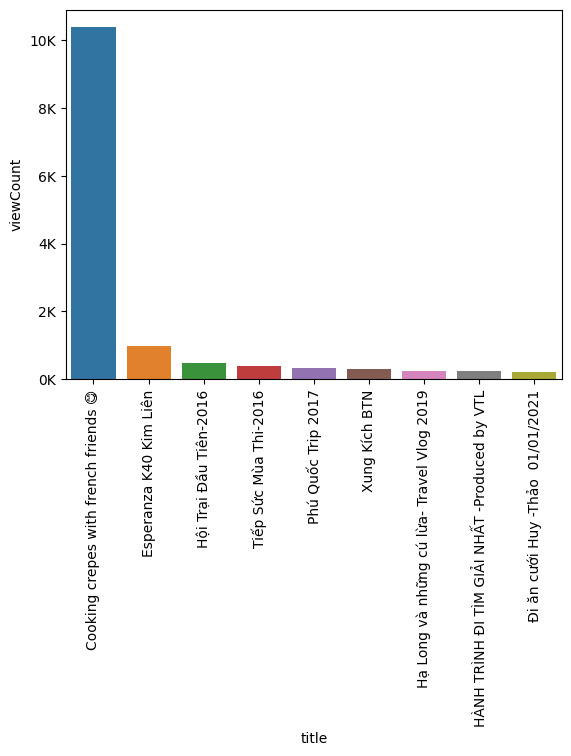

In [83]:
ax = sns.barplot(x='title', y='viewCount', data=video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

# Worst performing videos

/home/nhat/Documents/Project/youtube_api/my_env/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 127468 (\N{REGIONAL INDICATOR SYMBOL LETTER G}) missing from current font.
  func(*args, **kwargs)
/home/nhat/Documents/Project/youtube_api/my_env/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from current font.
  func(*args, **kwargs)
/home/nhat/Documents/Project/youtube_api/my_env/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 127809 (\N{MAPLE LEAF}) missing from current font.
  func(*args, **kwargs)
/home/nhat/Documents/Project/youtube_api/my_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127468 (\N{REGIONAL INDICATOR SYMBOL LETTER G}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/nhat/Documents/Project/youtube_api/my_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarni

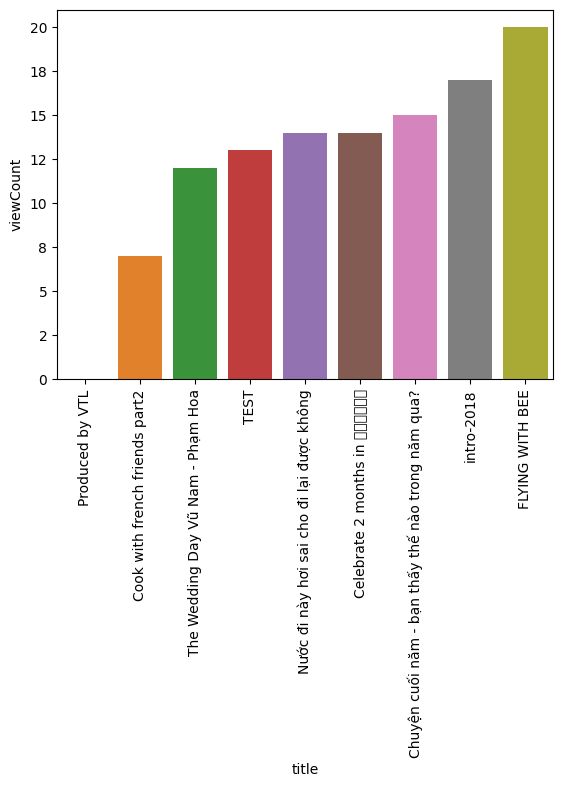

In [99]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x)))





In [23]:
request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
response = request.execute()
print(response['items'])

[{'kind': 'youtube#channel', 'etag': '3vgjCLQjF98gbvEylxYmBkvdcZo', 'id': 'UCIUt1auGAZGqo3jmeP-LB1g', 'snippet': {'title': 'Vê Tê Lờ', 'description': 'Kênh lưu giữ kỉ niệm của cuộc đời Vê Tê Lờ \nCapturing every moment as if its your last \nFLYING WITH ME', 'customUrl': '@vetelo612', 'publishedAt': '2015-07-29T17:05:51Z', 'thumbnails': {'default': {'url': 'https://yt3.ggpht.com/vmuIMuBTsLbCPEZ3s8W4BQxMS4b8JA6l7dntD-X-Njf-HmmgFgjo9tZM7MCezbeH1S27c4Km=s88-c-k-c0x00ffffff-no-rj', 'width': 88, 'height': 88}, 'medium': {'url': 'https://yt3.ggpht.com/vmuIMuBTsLbCPEZ3s8W4BQxMS4b8JA6l7dntD-X-Njf-HmmgFgjo9tZM7MCezbeH1S27c4Km=s240-c-k-c0x00ffffff-no-rj', 'width': 240, 'height': 240}, 'high': {'url': 'https://yt3.ggpht.com/vmuIMuBTsLbCPEZ3s8W4BQxMS4b8JA6l7dntD-X-Njf-HmmgFgjo9tZM7MCezbeH1S27c4Km=s800-c-k-c0x00ffffff-no-rj', 'width': 800, 'height': 800}}, 'localized': {'title': 'Vê Tê Lờ', 'description': 'Kênh lưu giữ kỉ niệm của cuộc đời Vê Tê Lờ \nCapturing every moment as if its your last \nFLYI

# Get video comments

In [71]:
def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    parent_ids = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id,
                maxResults=30
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:30]]
            replies = [comment['replies']['comments']['snippet']['textOriginal'] for comment in response['items'][0:30]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video, 'replies': replies}
            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)     

comment_df = get_comments_in_videos(youtube, ['9f6BxN2boCY'])

Could not get comments for video 9f6BxN2boCY


In [72]:
comment_df

""


In [70]:
len(comment_df['comments'][0])

24

In [78]:
request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId='9f6BxN2boCY',
                maxResults=30
            )
response = request.execute()
print(response)
# comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:30]]
# replies = [comment['replies']['comments']['snippet']['textOriginal'] for comment in response['items'][0:30]]
# comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}
# all_comments.append(comments_in_video_info) 

{'kind': 'youtube#commentThreadListResponse', 'etag': 'gmsOZf6lkBYZXaQejukEjB0lDiM', 'pageInfo': {'totalResults': 24, 'resultsPerPage': 30}, 'items': [{'kind': 'youtube#commentThread', 'etag': 'tUKOqwdIPMLarOLiR2s3iVJkRW8', 'id': 'Ugwa3T138VEGC8d2kN94AaABAg', 'snippet': {'videoId': '9f6BxN2boCY', 'topLevelComment': {'kind': 'youtube#comment', 'etag': 'BlaUfglRLvffD-hj_7A2yv3kezU', 'id': 'Ugwa3T138VEGC8d2kN94AaABAg', 'snippet': {'videoId': '9f6BxN2boCY', 'textDisplay': 'Yêu chị so much❤', 'textOriginal': 'Yêu chị so much❤', 'authorDisplayName': 'Kim Nghi', 'authorProfileImageUrl': 'https://yt3.ggpht.com/ytc/AL5GRJVRCZif_UW1TBixLi81qZHj_bAggFjepbvxU3CD=s48-c-k-c0x00ffffff-no-rj', 'authorChannelUrl': 'http://www.youtube.com/channel/UC_DScjeV6gqKNc7bLSEyNvg', 'authorChannelId': {'value': 'UC_DScjeV6gqKNc7bLSEyNvg'}, 'canRate': True, 'viewerRating': 'none', 'likeCount': 0, 'publishedAt': '2021-01-28T09:24:09Z', 'updatedAt': '2021-01-28T09:24:09Z'}}, 'canReply': True, 'totalReplyCount': 0, '

In [18]:
#TEST OnLY
def get_channel_stats(youtube, channel_ids):
    all_data = []

    request = youtube.channels().list(
    part="snippet, statistics, contentDetails",
    id=','.join(channel_ids)
    )
    response = request.execute()
    JSON(response['items'])
    #loop through items
#     for item in response['items']:
#         data = {'channelName': item['snippet']['title'],
#                 'subcribers': item['statistics']['subscriberCount'],
#                 'views': item['statistics']['viewCount'],
#                 'totalViews': item['statistics']['videoCount'],
#                 'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
#                 }
        
#     all_data.append(data)

#     return pd.DataFrame(all_data)
get_channel_stats(youtube, channel_ids)